In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import ast

In [2]:
prices = pd.read_json('stock_prices.json')
sentiments = pd.read_json('aligned_sentiments.json')

indices = []

for item in prices.columns.values:
    indices.append(ast.literal_eval(item))
    
prices.columns = pd.MultiIndex.from_tuples(indices)

indices = []

for item in sentiments.columns.values:
    indices.append(ast.literal_eval(item))
    
sentiments.columns = pd.MultiIndex.from_tuples(indices)

In [5]:
prices.dropna(axis=1, inplace=True)

In [11]:
to_keep = prices['Close'].columns.values

clean_sentiments = sentiments.loc[:, (slice(None), to_keep)]

In [16]:
def trading_long(buy_prices, sell_prices, sentiments, holding_days, n_shares, days):
    
    capital = 1000000
    positions = {}
    final_capital = 0
    long_amounts = []
    
    largest_n = sentiments.apply(lambda x: pd.Series(x.nlargest(n_shares).index), axis=1)
    
    for day in range(days):
        
        if day % 100 == 0:
            print('Day ', day)
            
        if day < holding_days:
            best = largest_n.iloc[day, :n_shares].values
            amount = capital / (holding_days * n_shares)
            long_amounts.append(amount)
            long_positions = [(company, amount / buy_prices.iloc[day+1][company]) for company in best]
            positions[day] = {'long': long_positions}
        else:
            days_long = sum([shares * sell_prices.iloc[day][company] 
                          for company, shares in positions[day - holding_days]['long']])
            long_amounts.append(days_long / n_shares)
            
            if days - day <= holding_days:
                final_capital += days_long
            else:
                best = largest_n.iloc[day, :n_shares].values
                amount = days_long / n_shares
                long_positions = [(company, amount / buy_prices.iloc[day+1][company]) for company in best]
                positions[day] = {'long': long_positions}
                
    return final_capital / capital, positions, long_amounts

In [37]:
ratio, _, daily_amounts = trading_long(prices['Open'], prices['Close'], clean_sentiments['stanza_body'], 3, 3, len(sentiments.index))

Day  0
Day  100
Day  200
Day  300
Day  400
Day  500
Day  600
Day  700


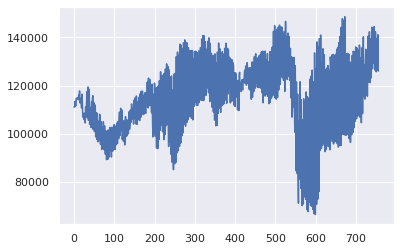

In [38]:
plt.plot(daily_amounts)

In [39]:
def trading_short(buy_prices, sell_prices, sentiments, holding_days, n_shares, days):
    
    capital = 1000000
    positions = {}
    final_capital = 0
    short_amounts = []
    
    smallest_n = sentiments.apply(lambda x: pd.Series(x.nsmallest(n_shares).index), axis=1)
    
    for day in range(days):
        
        if day % 100 == 0:
            print('Day ', day)
            
        if day < holding_days:
            worst = smallest_n.iloc[day, :n_shares].values
            amount = capital / (holding_days * n_shares)
            short_amounts.append(amount)
            short_positions = [(company, amount / sell_prices.iloc[day+holding_days][company]) for company in worst]
            positions[day] = {'short': short_positions}
        else:
            days_short = sum([shares * buy_prices.iloc[day - holding_days + 1][company] 
                          for company, shares in positions[day - holding_days]['short']])
            short_amounts.append(days_short / n_shares)
            
            if days - day <= holding_days:
                final_capital += days_short
            else:
                worst = smallest_n.iloc[day, :n_shares].values
                amount = days_short / n_shares
                short_positions = [(company, amount / sell_prices.iloc[day+holding_days][company]) for company in worst]
                positions[day] = {'short': short_positions}
                
    return final_capital / capital, positions, short_amounts

In [40]:
ratio, _, daily_amounts = trading_short(prices['Open'], prices['Close'], clean_sentiments['stanza_body'], 3, 3, len(sentiments.index))

Day  0
Day  100
Day  200
Day  300
Day  400
Day  500
Day  600
Day  700


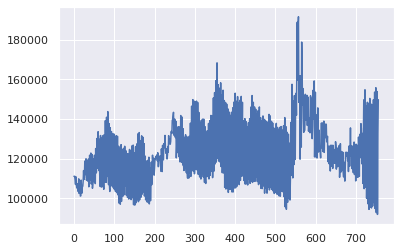

In [42]:
plt.plot(daily_amounts)

In [76]:
def trading_long_short(prices, sentiments, holding_days, n_shares, days):
    
    capital = 1000000
    positions = {}
    final_capital = 0
    long_amounts = []
    short_amounts = []
    
    open_prices = prices['Open']
    close_prices = prices['Close']
    
    largest_n = sentiments.apply(lambda x: pd.Series(x.nlargest(n_shares).index), axis=1)
    smallest_n = sentiments.apply(lambda x: pd.Series(x.nsmallest(n_shares).index), axis=1)
    
    for day in range(days):
        
        if day < holding_days:
            best = largest_n.iloc[day, :n_shares].values
            worst = smallest_n.iloc[day, :n_shares].values
            amount = capital / (2 * holding_days * n_shares)
            long_amounts.append(amount)
            short_amounts.append(amount)
            long_positions = [(company, amount / open_prices.iloc[day+1][company]) for company in best]
            short_positions = [(company, amount / close_prices.iloc[day+holding_days][company]) for company in worst]
            positions[day] = {'long': long_positions, 'short': short_positions}
        else:
            days_long = sum([shares * close_prices.iloc[day][company] 
                          for company, shares in positions[day - holding_days]['long']])
            long_amounts.append(days_long / n_shares)
            days_short = sum([shares * open_prices.iloc[day - holding_days + 1][company] 
                          for company, shares in positions[day - holding_days]['short']])
            short_amounts.append(days_short / n_shares)
            
            if days - day <= holding_days:
                final_capital += days_short + days_long
            else:
                best = largest_n.iloc[day, :n_shares].values
                worst = smallest_n.iloc[day, :n_shares].values
                amount = (days_short + days_long) / (2 * n_shares)
                long_positions = [(company, amount / open_prices.iloc[day+1][company]) for company in best]
                short_positions = [(company, amount / close_prices.iloc[day+holding_days][company]) for company in worst]
                positions[day] = {'long': long_positions, 'short': short_positions}
                
    return final_capital / capital, positions, short_amounts, long_amounts

In [75]:
def trading_short(prices, sentiments, holding_days, n_shares, days):
    
    capital = 1000000
    positions = {}
    final_capital = 0
    short_amounts = []
    
    open_prices = prices['Open']
    close_prices = prices['Close']
    
    smallest_n = sentiments.apply(lambda x: pd.Series(x.nsmallest(n_shares).index), axis=1)
    
    for day in range(days):
        
        if day < holding_days:
            worst = smallest_n.iloc[day, :n_shares].values
            amount = capital / (holding_days * n_shares)
            short_amounts.append(amount)
            short_positions = [(company, amount / close_prices.iloc[day+holding_days][company]) for company in worst]
            positions[day] = {'short': short_positions}
        else:
            days_short = sum([shares * open_prices.iloc[day - holding_days + 1][company] 
                          for company, shares in positions[day - holding_days]['short']])
            short_amounts.append(days_short / n_shares)
            
            if days - day <= holding_days:
                final_capital += days_short
            else:
                worst = smallest_n.iloc[day, :n_shares].values
                amount = (days_short) / (n_shares)
                short_positions = [(company, amount / close_prices.iloc[day+holding_days][company]) for company in worst]
                positions[day] = {'short': short_positions}
                
    return final_capital / capital, positions, short_amounts

In [74]:
def trading_long(prices, sentiments, holding_days, n_shares, days):
    
    capital = 1000000
    positions = {}
    final_capital = 0
    long_amounts = []
    
    open_prices = prices['Open']
    close_prices = prices['Close']
    
    largest_n = sentiments.apply(lambda x: pd.Series(x.nlargest(n_shares).index), axis=1)
    
    for day in range(days):
        
        if day < holding_days:
            best = largest_n.iloc[day, :n_shares].values
            amount = capital / (holding_days * n_shares)
            long_amounts.append(amount)
            long_positions = [(company, amount / open_prices.iloc[day+1][company]) for company in best]
            positions[day] = {'long': long_positions}
        else:
            days_long = sum([shares * close_prices.iloc[day][company] 
                          for company, shares in positions[day - holding_days]['long']])
            long_amounts.append(days_long / n_shares)
            
            if days - day <= holding_days:
                final_capital += days_long
            else:
                best = largest_n.iloc[day, :n_shares].values
                amount = (days_long) / (n_shares)
                long_positions = [(company, amount / open_prices.iloc[day+1][company]) for company in best]
                positions[day] = {'long': long_positions}
                
    return final_capital / capital, positions, long_amounts

In [50]:
trading_short(prices, clean_sentiments['stanza_body'], 3, 3, len(sentiments.index))

Day  0
Day  100
Day  200
Day  300
Day  400
Day  500
Day  600
Day  700


(1.1238890610597836,
 {0: {'short': [('MCD', 638.3861485945663),
    ('NFLX', 529.1257117220713),
    ('NKE', 1736.6538278548178)]},
  1: {'short': [('IBM', 710.9697503288637),
    ('HAS', 1192.5631994720788),
    ('TSLA', 1651.4240798617607)]},
  2: {'short': [('INTC', 2547.2515779878618),
    ('AAPL', 2549.4432385470313),
    ('WBA', 1513.3630329914215)]},
  3: {'short': [('MS', 2025.7139736955453),
    ('FB', 581.5947473887711),
    ('PNC', 730.1614676171706)]},
  4: {'short': [('GOOG', 96.79248591775526),
    ('AAPL', 2441.9450403366454),
    ('CMCSA', 2511.8787501207976)]},
  5: {'short': [('BA', 329.6838896321474),
    ('DAL', 1852.6326980403253),
    ('TMUS', 1740.6252698629016)]},
  6: {'short': [('WHR', 634.5149729942582),
    ('F', 8183.3053151936),
    ('NVDA', 1948.140519807022)]},
  7: {'short': [('AMD', 8641.171307203022),
    ('SCHW', 1876.439095608374),
    ('BSX', 3862.365840697919)]},
  8: {'short': [('FB', 592.3959994390088),
    ('WFC', 1665.563740990607),
    ('AFL

In [124]:
n = 10
h = 10
sources = ['bert_body', 'stanza_body', 'textblob_body', 'vader_body']
days = len(clean_sentiments.index)

ratio_heatmaps = []

for source in sources:
    print('Source: ', source)
    long_short = []

    for n_shares in range(1, n + 1):
        long_short_returns = []
        print('\tN_shares: ', n_shares)

        for holding_days in range(1, h + 1):
            ratio, _, _, _ = trading_long_short(prices, clean_sentiments[source], holding_days, n_shares, days)
            long_short_returns.append(ratio)

        long_short.append(long_short_returns)
    
    ratio_heatmaps.append(long_short)

Source:  bert_body
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  stanza_body
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  textblob_body
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  vader_body
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10


In [162]:
def plot_returns(ratios, sources, title, cmap, figsize, vmin, vmax, filename=None):
    fig, ax = plt.subplots(len(ratios), 1, figsize=figsize, sharex=True)
    
    g1 = sns.heatmap(ratios[0], cmap=cmap, ax=ax[0], yticklabels=range(1,11), annot=True, vmin=vmin, vmax=vmax)
    g1.set_ylabel('# Shares')
    g1.set_xlabel('')
    g1.set_title('Finbert')
    
    g2 = sns.heatmap(ratios[1], cmap=cmap, ax=ax[1], yticklabels=range(1,11), annot=True, vmin=vmin, vmax=vmax)
    g2.set_ylabel('# Shares')
    g2.set_xlabel('')
    g2.set_title('Stanza')
    
    g3 = sns.heatmap(ratios[2], cmap=cmap, ax=ax[2], yticklabels=range(1,11), annot=True, vmin=vmin, vmax=vmax)
    g3.set_ylabel('# Shares')
    g3.set_xlabel('')
    g3.set_title('Textblob')
    
    g4 = sns.heatmap(ratios[3], cmap=cmap, ax=ax[3],
                     xticklabels=range(1,11), yticklabels=range(1,11), annot=True, vmin=vmin, vmax=vmax)
    g4.set_ylabel('# Shares')
    g4.set_xlabel('# Days')
    g4.set_title('Vader')
    
    fig.suptitle(title, fontweight='bold')
    fig.tight_layout()
    if filename:
        plt.savefig(filename + '.jpg')

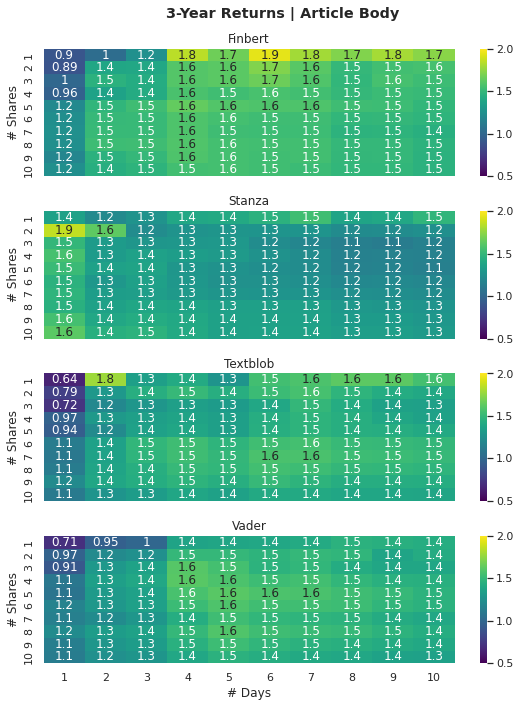

In [163]:
sources = ['bert_body', 'stanza_body', 'textblob_body', 'vader_body']

plot_returns(ratio_heatmaps, sources, '3-Year Returns | Article Body', 'viridis', (8, 10), .5, 2, filename='returns_body')

In [145]:
n = 10
h = 10
sources = ['bert_title', 'stanza_title', 'textblob_title', 'vader_title']
days = len(clean_sentiments.index)

title_ratio_heatmaps = []

for source in sources:
    print('Source: ', source)
    long_short = []

    for n_shares in range(1, n + 1):
        long_short_returns = []
        print('\tN_shares: ', n_shares)

        for holding_days in range(1, h + 1):
            ratio, _, _, _ = trading_long_short(prices, clean_sentiments[source], holding_days, n_shares, days)
            long_short_returns.append(ratio)

        long_short.append(long_short_returns)
    
    title_ratio_heatmaps.append(long_short)

Source:  bert_title
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  stanza_title
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  textblob_title
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10
Source:  vader_title
	N_shares:  1
	N_shares:  2
	N_shares:  3
	N_shares:  4
	N_shares:  5
	N_shares:  6
	N_shares:  7
	N_shares:  8
	N_shares:  9
	N_shares:  10


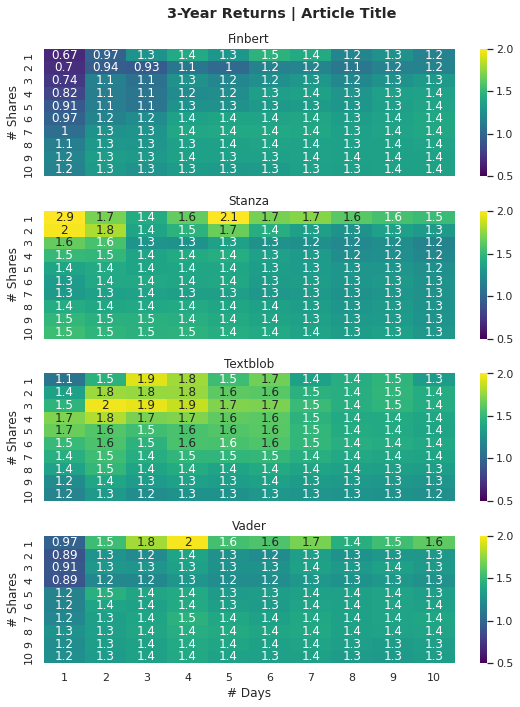

In [166]:
sources = ['bert_title', 'stanza_title', 'textblob_title', 'vader_title']

plot_returns(title_ratio_heatmaps, sources, '3-Year Returns | Article Title', 'viridis', (8, 10), .5, 2, filename='returns_title')

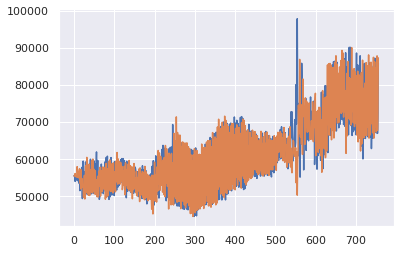

In [171]:
ratio, _, longs, shorts = trading_long_short(prices, clean_sentiments['vader_body'], 3, 3, days)
plt.plot(longs)
plt.plot(shorts)